<a href="https://colab.research.google.com/github/rrizkiramadhan08/RizkiRamadhanTask/blob/main/Week07/Week_7_Worksheet_of_7_XGBoost_data_melb_Rizki_Ramadhan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

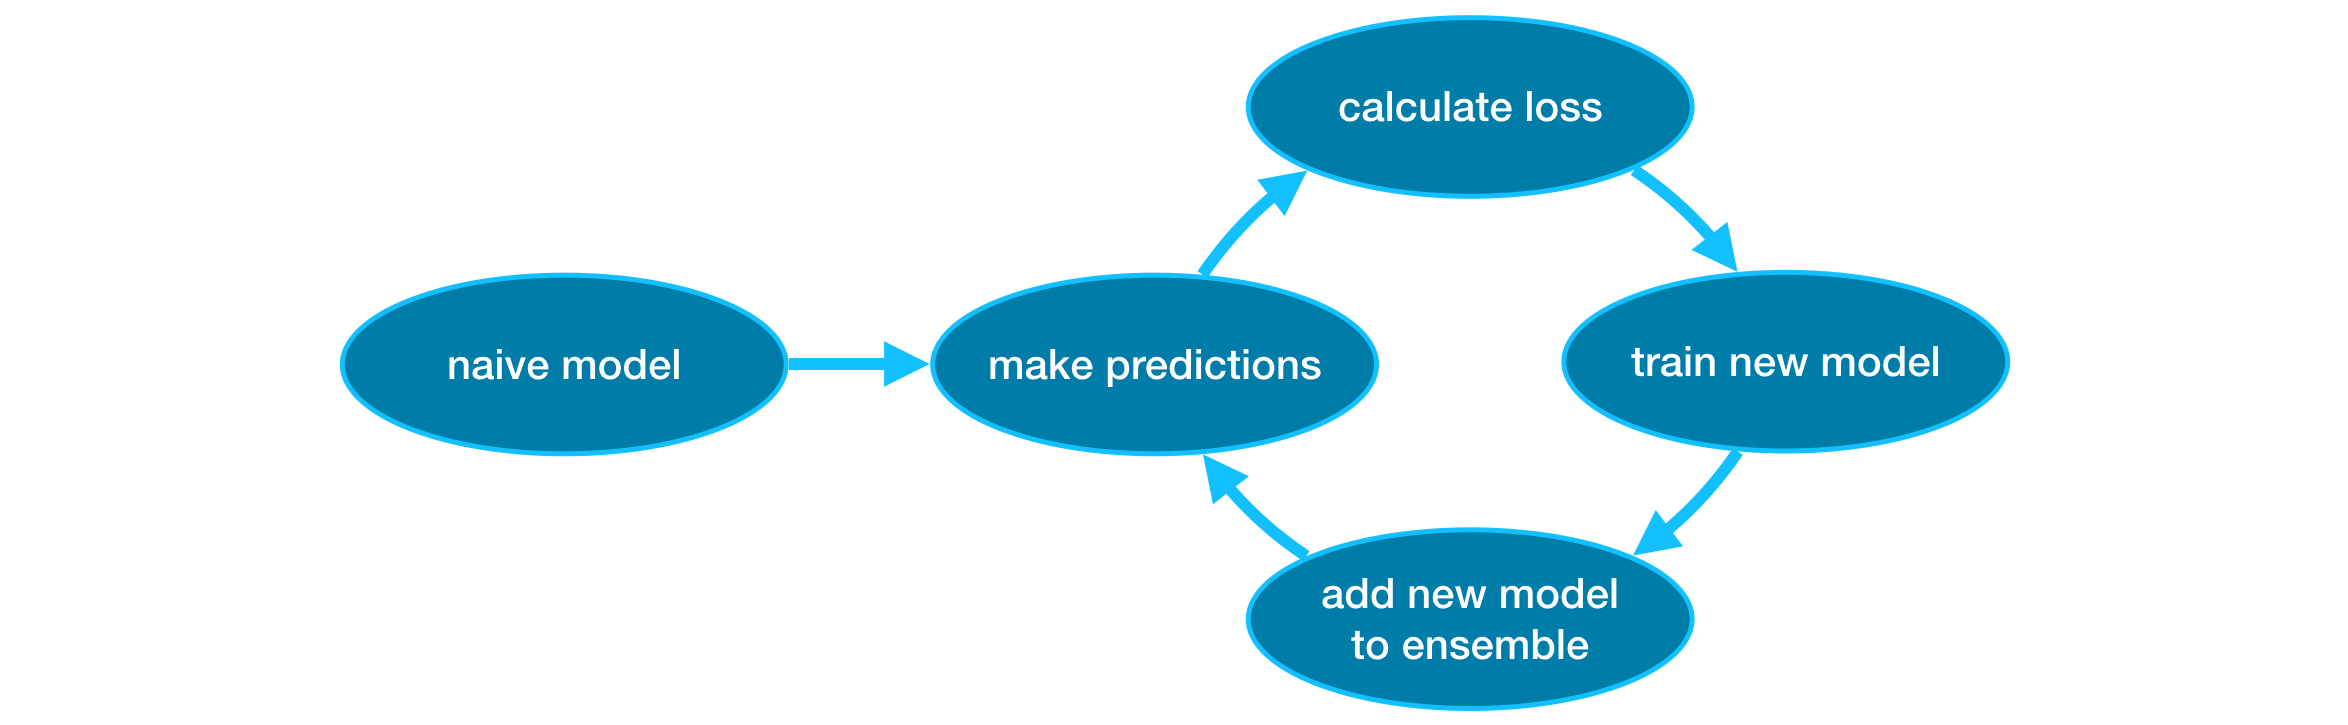

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

Importing Library

In [56]:
import pandas as pd  # Import library pandas untuk manipulasi data
from sklearn.model_selection import train_test_split  # Import fungsi untuk membagi dataset menjadi training dan validation set
from xgboost import XGBRegressor, plot_tree  # Import model XGBoost Regressor untuk regresi dan fungsi untuk plot tree
from sklearn.metrics import mean_absolute_error  # Import fungsi untuk menghitung Mean Absolute Error (MAE)
import matplotlib.pyplot as plt  # Import library matplotlib untuk visualisasi
from sklearn.model_selection import learning_curve  # Import fungsi untuk membuat learning curve
import numpy as np  # Import library numpy untuk perhitungan numerik
import shap  # Import library SHAP untuk interpretasi model
from sklearn.inspection import PartialDependenceDisplay  # Import fungsi untuk membuat Partial Dependence Plot


**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [31]:

from google.colab import drive  # Import modul untuk mengakses Google Drive dari Google Colab
drive.mount('/content/drive')  # Mount Google Drive untuk mengakses file di dalamnya

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [32]:


# Ganti 'your_file.csv' dengan path ke file yang ada di Google Drive
file_path = '/content/drive/MyDrive/DATA SET/melb_data.csv' # Menentukan path ke file CSV

# Membaca file CSV ke dalam DataFrame
df = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari DataFrame untuk memastikan data sudah ter-load dengan benar
df.head()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [33]:
# Menentukan variabel prediktor dan variabel target
predictors = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Price' # Variabel target yang ingin diprediksi


# Memilih variabel prediktor dan target dari DataFrame
X = df[predictors] # Menyimpan fitur-fitur prediktor ke dalam variabel 'X'
y = df[target] # Menyimpan variabel target ke dalam variabel 'y'


# Menampilkan beberapa baris pertama dari X dan y untuk memverifikasi data
X.head(), y.head()  # Menampilkan 5 baris pertama dari X dan y


(   Rooms  Distance  Landsize  BuildingArea  YearBuilt
 0      2       2.5     202.0           NaN        NaN
 1      2       2.5     156.0          79.0     1900.0
 2      3       2.5     134.0         150.0     1900.0
 3      3       2.5      94.0           NaN        NaN
 4      4       2.5     120.0         142.0     2014.0,
 0    1480000.0
 1    1035000.0
 2    1465000.0
 3     850000.0
 4    1600000.0
 Name: Price, dtype: float64)

**Prompt:**

Write a code cell to split the data into training and validation

In [34]:
# Membagi data menjadi training set dan validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # Membagi data dengan 80% untuk pelatihan dan 20% untuk validasi

# Memeriksa bentuk dari dataset yang dihasilkan
X_train.shape, X_val.shape, y_train.shape, y_val.shape  # Menampilkan jumlah baris dan kolom dari masing-masing subset


((10864, 5), (2716, 5), (10864,), (2716,))

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [35]:
# Mendefinisikan dan melatih model XGBoost Regressor
model = XGBRegressor(random_state=0)  # Membuat model XGBoost Regressor dengan seed acak 0
model.fit(X_train, y_train)  # Melatih model dengan data training

# Melakukan prediksi pada validation set
y_pred = model.predict(X_val)  # Menggunakan model untuk memprediksi data validasi

# Menghitung dan mencetak Mean Absolute Error (MAE) dari prediksi
mae = mean_absolute_error(y_val, y_pred)  # Menghitung MAE antara nilai sebenarnya dan prediksi
print("Mean Absolute Error on validation set:", mae)  # Mencetak nilai MAE untuk validation set

Mean Absolute Error on validation set: 230850.8424498343


Insight :  Nilai MAE yang mencapai 230,850 cukup tinggi, yang berarti rata-rata prediksi harga properti meleset sebesar 230,850 unit dari harga aslinya.

We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [36]:
# Mendefinisikan model dengan 500 estimators
model_500 = XGBRegressor(n_estimators=500, random_state=0)  # Membuat model XGBoost Regressor dengan 500 estimator

# Melatih model dengan 500 estimators
model_500.fit(X_train, y_train)  # Melatih model dengan data training

# Melakukan prediksi pada validation set
y_pred_500 = model_500.predict(X_val)  # Menggunakan model untuk memprediksi data validasi

# Menghitung dan mencetak Mean Absolute Error (MAE) dari model dengan 500 estimators
mae_500 = mean_absolute_error(y_val, y_pred_500)  # Menghitung MAE antara nilai sebenarnya dan prediksi
print("Mean Absolute Error on validation set with 500 estimators:", mae_500)  # Mencetak nilai MAE untuk validation set dengan 500 estimator


Mean Absolute Error on validation set with 500 estimators: 243749.46732326952


Insight : nilai Mean Absolute Error (MAE) pada validation set menggunakan model XGBoost dengan 500 estimator adalah sekitar 243,749.47. Ini merupakan peningkatan dalam nilai kesalahan (MAE lebih tinggi) dibandingkan dengan model sebelumnya yang menggunakan default estimator (230,850.84).

MAE yang lebih tinggi dengan jumlah estimator lebih besar (500) menunjukkan bahwa model mungkin mengalami overfitting.

The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

**Prompt:**

Write a code cell to train an XGBRegressor with 110 estimators and early stopping rounds, and print the mean absolute error on the validation set.

In [37]:
# Define the model with 110 estimators and early stopping
model_110 = XGBRegressor(n_estimators=110, early_stopping_rounds=10, random_state=0)

# Train the model with early stopping
model_110.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)  # Set verbose=True if you want to see training progress

# Make predictions on the validation set
y_pred_110 = model_110.predict(X_val)

# Calculate and print the Mean Absolute Error (MAE)
mae_110 = mean_absolute_error(y_val, y_pred_110)
print("Mean Absolute Error on validation set with 110 estimators and early stopping:", mae_110)


Mean Absolute Error on validation set with 110 estimators and early stopping: 229719.7476240335


Insight : Dengan menggunakan 110 estimators dan menerapkan early stopping, model menghasilkan nilai Mean Absolute Error (MAE) sebesar sekitar 229,719.75. Ini merupakan perbaikan jika dibandingkan dengan dua percobaan sebelumnya, yang masing-masing memiliki MAE sebesar 230,850.84 dan 243,749.47.


Nilai MAE sebesar 229,719.75 adalah lebih rendah dibandingkan kedua model sebelumnya, yang menunjukkan bahwa penggunaan early stopping berhasil membantu model menghentikan pelatihan pada titik optimal sebelum terjadi overfitting.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [38]:
# Define the model with a custom learning rate, 90 estimators, and early stopping
model_custom = XGBRegressor(n_estimators=90, learning_rate=0.05, early_stopping_rounds=10, random_state=0)

# Train the model with early stopping
model_custom.fit(X_train, y_train,
                 eval_set=[(X_val, y_val)],
                 verbose=False)  # Set verbose=True to view training progress

# Make predictions on the validation set
y_pred_custom = model_custom.predict(X_val)

# Calculate and print the Mean Absolute Error (MAE)
mae_custom = mean_absolute_error(y_val, y_pred_custom)
print("Mean Absolute Error on validation set with custom learning rate and 90 estimators:", mae_custom)


Mean Absolute Error on validation set with custom learning rate and 90 estimators: 248182.02224088734


Insight : nilai Mean Absolute Error (MAE) pada validation set setelah menggunakan learning rate yang diatur secara kustom dan 90 estimators adalah sekitar 248,182.02. Nilai MAE ini lebih tinggi dibandingkan hasil dengan menggunakan early stopping (229,719.75) maupun model default (230,850.84).

## Visualisasi Feature Importance

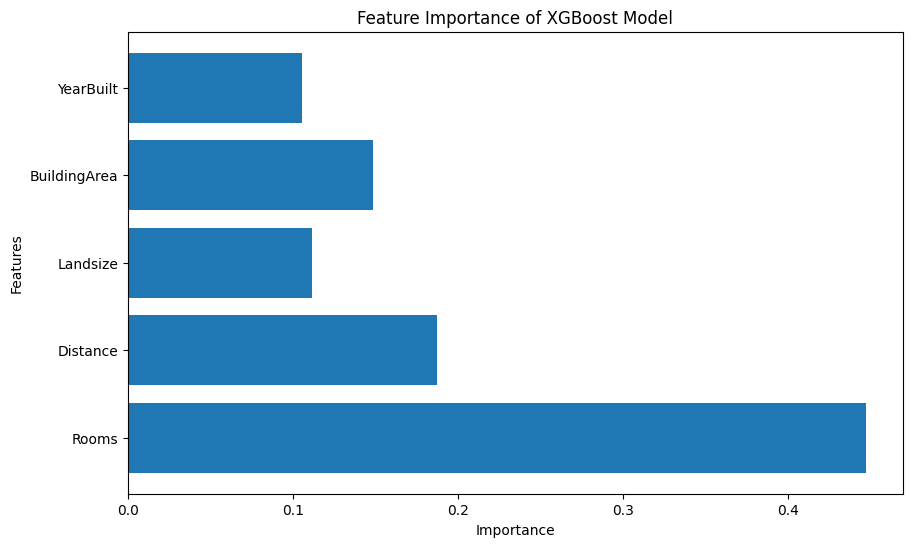

In [39]:
# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))  # Mengatur ukuran figure
plt.barh(predictors, model.feature_importances_)  # Membuat bar chart horizontal dari feature importance
plt.xlabel('Importance')  # Memberi label pada sumbu x
plt.ylabel('Features')  # Memberi label pada sumbu y
plt.title('Feature Importance of XGBoost Model')  # Memberi judul pada plot
plt.show()  # Menampilkan plot

insight : Grafik Feature Importance dari model XGBoost, yang menunjukkan seberapa penting setiap fitur dalam mempengaruhi prediksi model.
Fitur "Rooms" adalah yang paling signifikan: Fitur Rooms memiliki importance tertinggi. "Landsize" memiliki pengaruh lebih kecil: Fitur Landsize memiliki nilai importance yang lebih kecil dibandingkan fitur lainnya.

<Figure size 5000x10000 with 0 Axes>

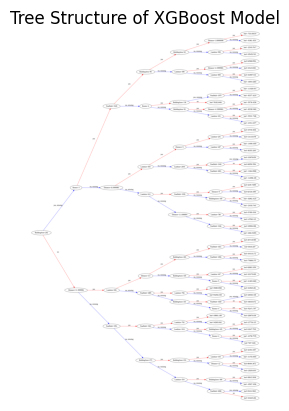

In [40]:
# Visualisasi Struktur Pohon
plt.figure(figsize=(50, 100))  # Mengatur ukuran figure
plot_tree(model, num_trees=2, rankdir='LR')  # Membuat visualisasi dari pohon pertama dalam model
plt.title('Tree Structure of XGBoost Model')  # Memberi judul pada plot
plt.show()  # Menampilkan plot

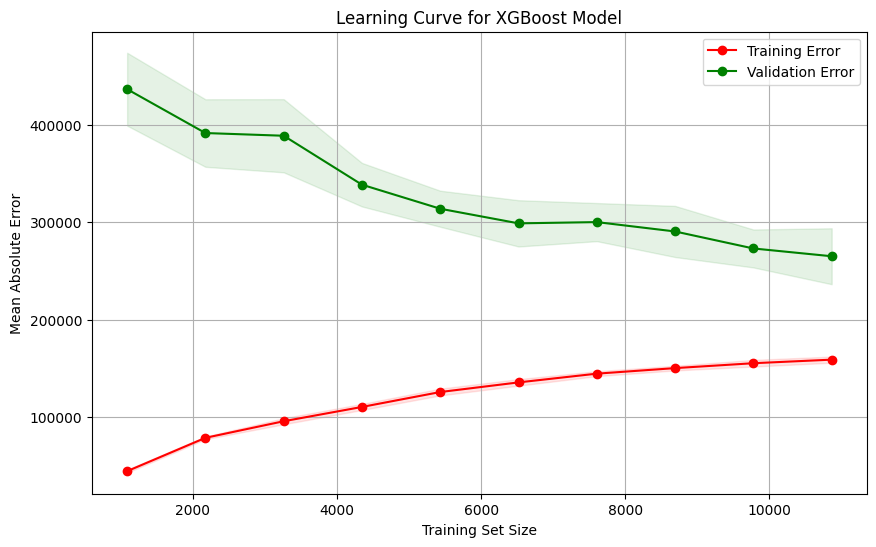

In [41]:
# Visualisasi Learning Curve
train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0)

# Menghitung rata-rata dan standar deviasi dari train dan validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Validation Error')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve for XGBoost Model')
plt.legend(loc='best')
plt.grid()
plt.show()


Insight : Grafik ini memberikan informasi tentang performa model saat ukuran dataset pelatihan meningkat, baik dari segi training error (garis merah) maupun validation error (garis hijau).

Training Error:

Garis merah menunjukkan training error, yang meningkat seiring bertambahnya ukuran data pelatihan. Pada awalnya, error cukup rendah ketika jumlah data pelatihan sedikit. Ini normal karena model dapat dengan mudah mengingat dataset kecil, yang menyebabkan overfitting.

Validation Error:

Garis hijau menunjukkan validation error, yang cenderung menurun seiring bertambahnya ukuran data pelatihan.
Hal ini menunjukkan bahwa model menjadi lebih baik dalam melakukan generalisasi terhadap data baru ketika diberi lebih banyak data pelatihan.

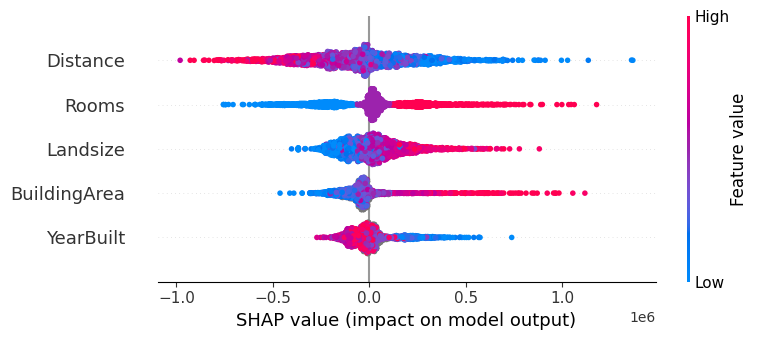

In [43]:
# Menghitung SHAP Values untuk interpretasi model
explainer = shap.Explainer(model, X_train)  # Membuat objek SHAP explainer
shap_values = explainer(X_val)  # Menghitung SHAP values untuk data validasi

# Visualisasi SHAP Summary Plot
shap.summary_plot(shap_values, X_val)  # Membuat summary plot dari SHAP values untuk melihat kontribusi fitur secara keseluruhan


Insight : Merupakan SHAP summary plot, yang menunjukkan pengaruh setiap fitur terhadap output model XGBoost dalam hal kontribusi positif atau negatif pada prediksi harga.

SHAP value menggambarkan dampak setiap fitur terhadap prediksi model, baik dalam arah positif atau negatif. Fitur Distance dan Rooms adalah dua fitur yang paling berpengaruh terhadap prediksi harga, dengan Rooms cenderung meningkatkan harga dan Distance cenderung menguranginya. Fitur Landsize, BuildingArea, dan YearBuilt juga berkontribusi, tetapi dampaknya lebih variatif dan kontekstual.

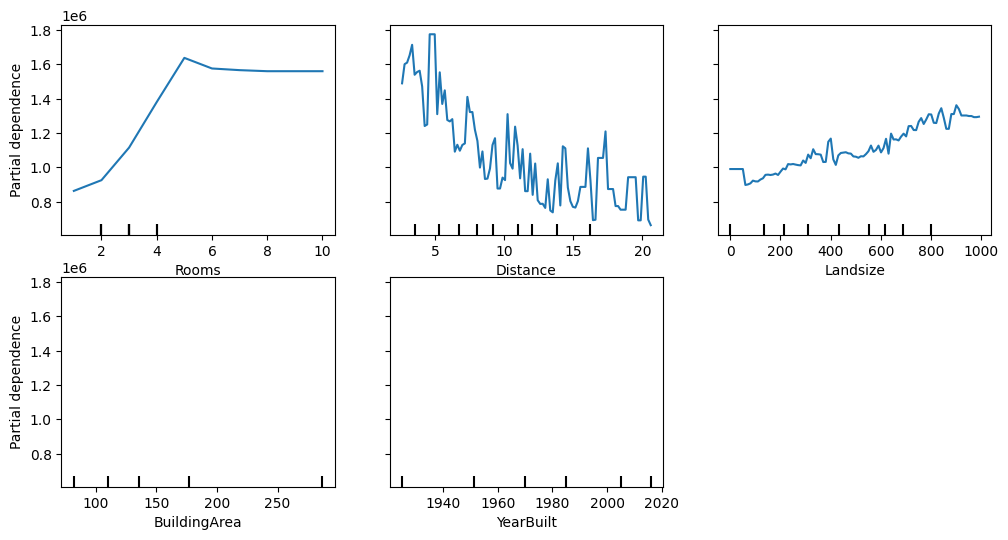

In [58]:
# Visualisasi Partial Dependence Plot
fig, ax = plt.subplots(figsize=(12, 6))  # Mengatur ukuran figure
PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3, 4], feature_names=predictors, ax=ax)  # Membuat Partial Dependence Plot untuk semua fitur
plt.title('')  # Memberi judul pada plot
plt.show()  # Menampilkan plot


Insight:

Rooms:Harga properti meningkat secara signifikan dengan bertambahnya jumlah kamar (Rooms). Hal ini menunjukkan bahwa lebih banyak kamar secara langsung meningkatkan nilai properti, hingga pada titik tertentu harga stabil.

Distance:Ketika jarak (Distance) ke pusat kota atau lokasi tertentu meningkat, harga properti cenderung menurun. Jarak yang lebih jauh biasanya mengurangi nilai properti karena aksesibilitas yang lebih rendah.

Landsize:Luas lahan (Landsize) memiliki hubungan yang cukup linier dengan harga properti. Semakin besar luas lahan, semakin tinggi pula harga properti, yang wajar karena lebih banyak tanah biasanya berarti nilai yang lebih besar.

BuildingArea dan YearBuilt:Tidak ada pola yang terlihat pada plot BuildingArea dan YearBuilt. Ini mungkin terjadi karena kurangnya data yang cukup untuk nilai tertentu, atau fitur-fitur ini tidak berkontribusi secara signifikan dalam memengaruhi harga.